In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
# import seaborn as sns

## 関数の定義

In [5]:
def hensai(rental, nenri, years):
    
    """
    Description
    ----------
    借入金額(total)と年利(nenri)と返済期間(years)から
    月々の返済額を求める。
    
    Input
    ----------
    rental: int, 借入金額
    nenri: float, 金利(%表示ではなく、割合表示）
    years: int, 返済期間[年]
    
    Output
    ----------
    hensai_gaku: 月々の返済額
    """
    
    tukiri = nenri / 12
    hensai_gaku = rental * tukiri * (1+tukiri)**(years*12) / ((1 + tukiri) ** (years*12) -1)
    hensai_gaku = int(hensai_gaku)
    return hensai_gaku


def hensai10(rental, nenri, years, first_years=10):
    
    """
    Description
    ----------
    10年後に段階的に金利が変わる時に用いる
    借入金額(total)と年利(nenri)と返済期間(years)から
    月々の返済額を求める。
    
    ただし、11年目以降の返済額を求めるために必要な10年支払い後の返済額(hensai_gaku)も返す
    ※ first_yearsを変更することで、金利が変わる年を変更できる
    
    Input
    ----------
    rental: int, 借入金額
    nenri: float, 金利(%表示ではなく、割合表示）
    years: int, 返済期間[年]
    first_years: int, 金利が変わるまでの期間[年]
    
    Output
    ----------
    hensai_gaku: 月々の返済額
    gankin: 10年返済した後の元金(11年目以降の返済額を計算するのに必要）
    """


    hensai_gaku = hensai(rental, nenri, years)
    gankin = rental
    for i in range(first_years * 12):
        risoku = gankin * (nenri / 12)
        gankin_hensai = hensai_gaku - risoku
        gankin -= gankin_hensai
    return hensai_gaku, int(gankin)

def func_gankin(rental, nenri1, nenri2, years):
    """
    Description
    ----------
    10年後に段階的に金利が変わる時に用いる。
    借入金額(rental)と年利(nenri)と返済期間(years)から
    元金の推移を計算し、1年毎の元金をlistに返す。
    
    Input
    ----------
    rental: int, 借入金額
    nenri1, nenri2: float, 金利(%表示ではなく、割合表示）
    years: int, 返済期間[年]
    
    Output
    ----------
    gankin_list: list, 1年毎の元金の推移
    """
    
    _hensai_first, _gankin_first = hensai10(rental, rate1, years)
    _hensai_second = hensai(_gankin_first, rate2, years-10)
    
    # 元金推移計算
    _gankin = rental
    _gankin_list = []
    for y in range(years):
        
        _hensaigaku = _hensai_first if y + 1 <= 10 else _hensai_second
        _rate = nenri1 if y + 1 <= 10 else nenri2

        for i in range(12):
            _risoku = _gankin * (_rate / 12)
            _gankin_hensai = _hensaigaku - _risoku
            _gankin -= _gankin_hensai
        _gankin_list.append(int(_gankin))
    
    return _gankin_list


def zyutaku(rental, rate1, rate2, years, tatemono, hensai_max=500000, kuriage_years=None, kuriage=None):

    if tatemono * 0.01 >= hensai_max:
        tatemono = hensai_max * 100

    _hensai_first, _gankin_first = hensai10(rental, rate1, years)
    _hensai_second = hensai(_gankin_first, rate2, years-10)
    
    # 元金推移計算
    gankin_list = func_gankin(rental, rate1, rate2, years)

    # 住宅ローン控除額推移計算
    kouzyo_list = []
    for i, gan in enumerate(gankin_list[:13]):
        if i + 1 <= 10:
            kouzyo = hensai_max if gan * 0.01 >= hensai_max else gan * 0.01
        else:
            kouzyo = tatemono * 0.02 /3 if gan * 0.01 >= tatemono * 0.02 / 3 else gan * 0.01

        kouzyo_list.append(int(kouzyo))

    kouzyo_arr = np.array(kouzyo_list)
    
    return kouzyo_arr

In [6]:
def hensai_detail(rental, tatemono, rate1, rate2, years, kaishi_list, kuriage_list, kuriage_gaku,
                  change_year=11, hensai_max=500000):
    """
    Description
    ----------
    月々の返済額などを整理したDataFrameを返す関数
    その他、住宅ローン控除総額、利息総額、返済期間[年]を返す
    
    Input
    ----------
    rental: int, 借入金額
    tatemono: int, 建物費用（11年目以降の控除額算出に使用)
    rate1: 金利(%表示ではなく、割合表示）_金利変更前
    rate2: 金利(%表示ではなく、割合表示）_金利変更後。ずっと固定金利の場合は、同じ数値を入れる
    years: int, 返済期間[年]
    kaishi_list: list[year, month]。2022年1月にローン借り入れの場合は、[2022, 1]とする
    kuriage_list: list[year, month]。2032年1月に繰り上げ返済する場合は、[2032, 1]とする。
    　　　　　　　　繰上返済しない場合は適当なlist(要素2つ以上）を入れて、kuriage_gaku=0とする
    kuriage_gaku: int, 繰上返済する金額。繰上返済しない場合は、0とする。
    change_year: 金利がいつ変更になるか(11年目に金利変更の場合には、11を入力する）
    hensai_max: 住宅ローン控除の年最大控除額（default=50万円), 長期優良住宅/低炭素住宅でない場合は40万にする
    
    Output
    ----------
    df_hensai: DataFrame, カラム="Date", "返済額", ”利息分", "借入残高"
    zyuutaku_gaku: int, 住宅ローン控除の総額
    total_risoku; int, 支払い完了までの利息の総額
    hensai_kikan: float, 返済完了期間。この関数では繰上返済=返済期間短縮。
    """
    #　初期設定
    date = kaishi_list.copy()
    date_list = [datetime.datetime(kaishi_list[0], kaishi_list[1], 1)]
    
    hensai_list = [0]
    risoku_list = [0]
    zandaka = rental
    zandaka_list = [zandaka]
    zyuutaku_list = []
    zyuutaku_gaku = 0

    # 返済額計算
    hensai_first, gankin_first = hensai10(rental, rate1, years, first_years=change_year)
    hensai_second = hensai(gankin_first, rate2, years-change_year)

    # 計算
    for count in range(years*12):

        # 日付の計算
        if date[1]  != 12:
            date[1] += 1
        else:
            date[0] +=1
            date[1] = 1
        date_list.append(datetime.datetime(date[0], date[1], 1))

        # 返済額
        hensaigaku = hensai_first if count + 1 <= change_year * 12 else hensai_second

        # 利息分
        rate = rate1 if count + 1 <= change_year * 12 else rate2
        risoku = int(zandaka * rate /12) 

        if hensaigaku > zandaka + risoku:
            hensaigaku = zandaka + risoku

        # 残高計算
        zandaka_hensai = hensaigaku - risoku
        zandaka -= zandaka_hensai

        # 繰り上げ返済（期間短縮）
        if date == kuriage_list:
            zandaka -= kuriage_gaku
            hensaigaku += kuriage_gaku

        # list更新
        risoku_list.append(risoku)
        hensai_list.append(hensaigaku)
        zandaka_list.append(zandaka)

        # 住宅ローン控除計算
        if date[1] == 1:
            if count + 1 <= 10 * 12:
                kouzyo = hensai_max if zandaka * 0.01 >= hensai_max else zandaka * 0.01
                zyuutaku_list.append(int(kouzyo))
                zyuutaku_gaku += int(kouzyo)
            elif count + 1 <= 13 * 12:
                kouzyo = tatemono * 0.02 /3 if zandaka * 0.01 >= tatemono * 0.02 / 3 else zandaka * 0.01
                zyuutaku_list.append(int(kouzyo))
                zyuutaku_gaku += int(kouzyo)

        if zandaka == 0:
            break

    # dfに反映
    df_hensai = pd.DataFrame({"Date": date_list,
                   "返済額":hensai_list,
                   "利息分":risoku_list,
                   "借入残高":zandaka_list})
    
    total_risoku = df_hensai["利息分"].sum()
    hensai_kikan = round((df_hensai.shape[0]-1)/12, 1) # 単位:年
    
    return df_hensai, zyuutaku_gaku, total_risoku, hensai_kikan


## 簡易計算

In [7]:
# 計算前提
rental = 30000000 # 借用金額
tatemono = 15000000 # 建物代。11年目以降の住宅ローン控除額に効く
hensai_max = 500000 # 長期優良住宅, 低CO2 の場合は 50万。それ以外は 40万
years = 35 # 最初にローンを組む時の年数

# 利息関係
hosyou = 0.2/100
rate1, rate2 = 1.00/100, 1.30/100
rate1 += hosyou
rate2 += hosyou

# 計算
hensai_first, gankin_first = hensai10(rental, rate1, years)
hensai_second = hensai(gankin_first, rate2, years-10)
total_hensai = hensai_first * 12 * 10 + hensai_second * 12 * (years - 10)
total_risoku = total_hensai - rental
zyutaku_back = zyutaku(rental, rate1, rate2, years, tatemono, hensai_max).sum()

print(f"借り入れ額: {rental:,}")
print(f"total返済額: {total_hensai:,}")
print(f"total返済額(控除考慮): {total_hensai-zyutaku_back:,}")
print(f"利息額 {total_risoku:,}")
print(f"初期10年間の毎月返済額: {hensai_first:,}")
print(f"以降のの毎月返済額: {hensai_second:,}")
print(f"初期10年後の残元金: {gankin_first:,}")
print(f"住宅ローン減税の総額: {zyutaku_back:,}")
print(f"利息 - 住宅ローン減税総額: {total_risoku - zyutaku_back:,}")

借り入れ額: 30,000,000
total返済額: 37,702,500
total返済額(控除考慮): 34,798,322
利息額 7,702,500
初期10年間の毎月返済額: 87,510
以降のの毎月返済額: 90,671
初期10年後の残元金: 22,671,543
住宅ローン減税の総額: 2,904,178
利息 - 住宅ローン減税総額: 4,798,322


# 詳細計算

Money_to_spend を頭金と11年目の返済に分けて充てる（totalのお金は同じ）。  
この時の金利と住宅ローン控除の差額(借入金額以外に必要が額(Net)を計算する。

In [8]:
# hensai_detail関数を使った計算結果
hensai_detail(50_000_000, 33_000_000, 1.0/100, 1.3/100, 35, [2022,1], [2032,1], 5_000_000)

(          Date     返済額    利息分      借入残高
 0   2022-01-01       0      0  50000000
 1   2022-02-01  141142  41666  49900524
 2   2022-03-01  141142  41583  49800965
 3   2022-04-01  141142  41500  49701323
 4   2022-05-01  141142  41417  49601598
 ..         ...     ...    ...       ...
 370 2052-11-01  146088    776    571682
 371 2052-12-01  146088    619    426213
 372 2053-01-01  146088    461    280586
 373 2053-02-01  146088    303    134801
 374 2053-03-01  134947    146         0
 
 [375 rows x 4 columns],
 4930155,
 8972899,
 31.2)

In [12]:
# 計算前提(1)
total_cost = 30_000_000 # 家の値段（土地代やその他諸費用、消費税込み）
tatemono = 15_000_000 # 建物代。11年目以降の住宅ローン控除額に効く
hensai_max = 500_000 # 長期優良住宅, 低CO2 の場合は 50万。それ以外は 40万
years = 35 # 最初にローンを組む時の年数(頭金なし）

kaishi_list = [2022, 1] # ローン借りる年, 月
kuriage_list = [2032, 1] # 繰り上げ返済する年、月
# kuriage_gaku = 8_000_000 # 繰り上げ額

# 利息関係
hosyou = 0.2/100
rate1, rate2 = 1.0/100, 1.3/100
rate1 += hosyou
rate2 += hosyou
change_year = 10

# 計算前提(2) 
Money_to_spend = 5_000_000
atamakin = np.arange(0, Money_to_spend + 1, 1_000_000)

# 準備
delta_money_list = []
kuriage_gaku_list = []
rental_list = []
risoku_list = []
total_shiharai_list = []
total_shiharai_koujo_list = []
hensai_year_list = []
hensai_first_list = []
hensai_second_list = []
koujo_list = []

for i, atama in enumerate(atamakin):
    rental_years = years
    rental = total_cost - atama
    kuriage_gaku = Money_to_spend - atama
    
    hensai_first, gankin_first = hensai10(rental, rate1, rental_years, first_years=change_year)
    hensai_second = hensai(gankin_first, rate2, rental_years-change_year)
    
    df_hensai, koujo, total_risoku, hensai_year = hensai_detail(
        rental, tatemono, rate1, rate2, rental_years, kaishi_list, kuriage_list, kuriage_gaku)
    
    delta_money = total_risoku - koujo
    delta_money_list.append(delta_money)
    kuriage_gaku_list.append(kuriage_gaku)
    rental_list.append(rental)
    risoku_list.append(total_risoku)
    total_shiharai_list.append(rental + total_risoku + atama)
    total_shiharai_koujo_list.append(rental + total_risoku + atama - koujo)
    hensai_year_list.append(hensai_year)
    hensai_first_list.append(hensai_first)
    hensai_second_list.append(hensai_second)
    koujo_list.append(koujo)
 
df = pd.DataFrame({"頭金": atamakin,
                   "繰上返済額": kuriage_gaku_list,
                   "借入額": rental_list,
                   "利息額": risoku_list,
                   "総支払い額": total_shiharai_list,
                   "総支払い額(控除考慮)": total_shiharai_koujo_list,
                   "利息 - 控除": delta_money_list,
                   "返済期間":hensai_year_list,
                   "初期返済額": hensai_first_list,
                   "金利変更後返済額": hensai_second_list,
                   "控除額": koujo_list
                  })

pd.options.display.max_rows = 15
df

,頭金,繰上返済額,借入額,利息額,総支払い額,総支払い額(控除考慮),利息 - 控除,返済期間,初期返済額,金利変更後返済額,控除額
0,0,5000000,30000000,5714407,35714407,32860231,2860231,28.7,87510,90671,2854176
1,1000000,4000000,29000000,5798589,35798589,33021218,3021218,29.8,84593,87649,2777371
2,2000000,3000000,28000000,5901828,35901828,33201263,3201263,30.9,81676,84626,2700565
3,3000000,2000000,27000000,6027102,36027102,33403345,3403345,32.2,78759,81604,2623757
4,4000000,1000000,26000000,6177730,36177730,33630778,3630778,33.5,75842,78582,2546952
5,5000000,0,25000000,6358061,36358061,33887916,3887916,35.0,72925,75559,2470145


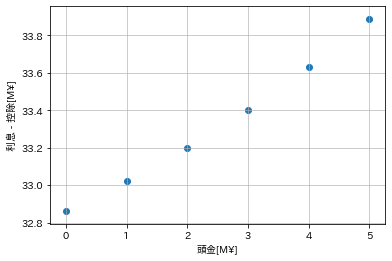

In [13]:
# 頭金と利息-控除の関係（頭金が少ない = 11年目に繰り上げ返済する額が多い)
plt.scatter(df["頭金"]/1_000_000, df["総支払い額(控除考慮)"]/1_000_000)
plt.xlabel("頭金[M¥]")
plt.ylabel("利息 - 控除[M¥]")
plt.grid(alpha=0.8)
plt.show()